<a href="https://colab.research.google.com/github/deep-diver/Continuous-Adaptation-for-Machine-Learning-System-to-Data-Changes/blob/main/notebooks/03_Batch_Prediction_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Batch Prediction Pipeline

The main purpose of this notebook is to build KFP pipeline doing the following steps

1. Create an batch request input file (file list format) based on the files uploaded to a GCS bucket
2. Run Batch Prediction on the trained model obtained from [02_TFX_Training_Pipeline.ipynb](https://github.com/deep-diver/Continuous-Adaptation-for-Machine-Learning-System-to-Data-Changes/blob/main/notebooks/02_TFX_Training_Pipeline.ipynb)
3. Measure the batch prediction model performance in terms of accuracy
4. If model **performance < threshold**
  - Copy the testing images to the original(previous) dataset
  - Trigger the TFX training pipeline with original data + newly added data

The functional test for batch prediction is shown in a separate notebook, [98_Batch_Prediction_Test.ipynb](https://github.com/deep-diver/Continuous-Adaptation-for-Machine-Learning-System-to-Data-Changes/blob/main/notebooks/98_Batch_Prediction_Test.ipynb).

## Setup

In [ ]:
!pip install fastdot
!pip install tfx==1.2.0
!pip install kfp==1.6.1
!pip install -q --upgrade google-cloud-aiplatform
!pip install -q --upgrade google-cloud-storage

### ***Restart runtime.***

In [ ]:
!gcloud init

In [ ]:
from google.colab import auth
auth.authenticate_user()

## Custom TFX Components

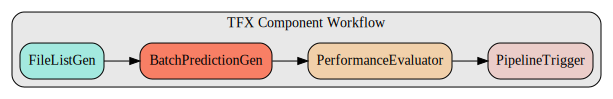

In [ ]:
# @title
from fastdot.core import *

tfx_components = [
    "FileListGen",
    "BatchPredictionGen",
    "PerformanceEvaluator",
    "PipelineTrigger",
]
block = "TFX Component Workflow"

g = graph_items(seq_cluster(tfx_components, block))
g

### **FileListGen Component**

- `FileListGen` will produce a `file list` file that `BatchPredictionGen` will refer to perform batch prediction on Vertex AI
- `file list` format can be found [here](https://cloud.google.com/vertex-ai/docs/predictions/batch-predictions)

**Spec**
- input
  - GCS path where the raw files are
  - GCS path where the `file list` file will be 
- output
  - GCS path where the `file list` file is

In [ ]:
_file_list_gen_module_file = 'file_list_gen.py'

In [ ]:
%%writefile {_file_list_gen_module_file}

import tfx
from tfx.dsl.component.experimental.decorators import component
from tfx.dsl.component.experimental.annotations import Parameter
from tfx.dsl.component.experimental.annotations import OutputArtifact
from tfx.types.standard_artifacts import String
from google.cloud import storage
from absl import logging


@component
def FileListGen(
    outpath: OutputArtifact[String],
    project: Parameter[str],
    gcs_source_bucket: Parameter[str],
    gcs_source_prefix: Parameter[str] = "",
    output_filename: Parameter[str] = "test-images.txt",
):
    logging.info("FileListGen started")

    client = storage.Client(project=project)
    bucket = client.get_bucket(gcs_source_bucket)
    blobs = bucket.list_blobs(prefix=gcs_source_prefix)
    logging.info("Successfully retrieve the file(jpg) list from GCS path")

    f = open(output_filename, "w")
    for blob in blobs:
        if blob.name.split(".")[-1] == "jpg":
            prefix = ""
            if gcs_source_prefix != "":
                prefix = f"/{gcs_source_prefix}"
            line = f"gs://{gcs_source_bucket}{prefix}/{blob.name}\n"
            f.write(line)
    f.close()
    logging.info(
        f"Successfully created the file list file({output_filename}) in local storage"
    )

    prefix = ""
    if gcs_source_prefix != "":
        prefix = f"{gcs_source_prefix}/"
    blob = bucket.blob(f"{prefix}{output_filename}")
    blob.upload_from_filename(output_filename)
    logging.info(f"Successfully uploaded the file list ({prefix}{output_filename})")

    outpath.value = gcs_source_bucket + "/" + prefix + output_filename

Writing file_list_gen.py


### BatchPredictionGen Component
- Behaviour of `BatchPredictionGen` is similar to TFX standard component `BulkInferrer`.
- The only difference is we don't need `Model` artifact from `Trainer` but just `model ID` that can be found in `Vertex AI Model` registry.
- Predicted results will be fed into the `PerformanceEvaluator` component.

**Spec**
- input
  - GCS path where the TFRecord file is
  - model id from Vertex AI Model
- output
  - predictions

In [ ]:
_batch_pred_module_file = 'batch_prediction_vertex.py'

In [ ]:
%%writefile {_batch_pred_module_file}

from google.cloud import storage

from tfx.dsl.component.experimental.annotations import Parameter, InputArtifact
from tfx.dsl.component.experimental.decorators import component
from tfx.types import artifact_utils
from tfx.types.standard_artifacts import String
import google.cloud.aiplatform as vertex_ai

from typing import Union, Sequence
from absl import logging


@component
def BatchPredictionGen(
    gcs_source: InputArtifact[String],
    project: Parameter[str],
    location: Parameter[str],
    model_resource_name: Parameter[str],
    job_display_name: Parameter[str],
    gcs_destination: Parameter[str],
    instances_format: Parameter[str] = "file-list",
    machine_type: Parameter[str] = "n1-standard-2",
    accelerator_count: Parameter[int] = 0,
    accelerator_type: Parameter[str] = None,
    starting_replica_count: Parameter[int] = 1,
    max_replica_count: Parameter[int] = 1,
):
    storage_client = storage.Client()

    # Read GCS Source (gcs_source contains the full path of GCS object)
    # 1-1. get bucketname from gcs_source
    gcs_source_uri = gcs_source.uri.split("//")[1:][0].split("/")
    bucketname = gcs_source_uri[0]
    bucket = storage_client.get_bucket(bucketname)
    logging.info(f"bucketname: {bucketname}")

    # 1-2. get object path without the bucketname
    objectpath = "/".join(gcs_source_uri[1:])

    # 1-3. read the object to get value set by OutputArtifact from FileListGen
    blob = bucket.blob(objectpath)
    logging.info(f"objectpath: {objectpath}")

    gcs_source = f"gs://{blob.download_as_text()}"

    # Get Model
    vertex_ai.init(project=project, location=location)

    model = vertex_ai.Model.list(
        filter=f"display_name={model_resource_name}", order_by="update_time"
    )[-1]

    # Batch Predictions
    logging.info("Starting batch prediction job.")
    logging.info(f"GCS path where file list is: {gcs_source}")

    batch_prediction_job = model.batch_predict(
        job_display_name=job_display_name,
        instances_format=instances_format,
        gcs_source=gcs_source,
        gcs_destination_prefix=gcs_destination,
        machine_type=machine_type,
        accelerator_count=accelerator_count,
        accelerator_type=accelerator_type,
        starting_replica_count=starting_replica_count,
        max_replica_count=max_replica_count,
        sync=True,
    )

    logging.info(batch_prediction_job.display_name)
    logging.info(batch_prediction_job.resource_name)
    logging.info(batch_prediction_job.state)

Overwriting batch_prediction_vertex.py


### **PerformanceEvaluator Component**
- Calculate any performance metrics 
- Outputs if the model performance is above or below the given threshold

**Spec**
- input
  - predictions
  - threshold
- output
  - `True` or `False` by the threshold

In [ ]:
_evaluator_module_file = 'batch_pred_evaluator.py'

In [ ]:
%%writefile {_evaluator_module_file}

# Reference: https://bit.ly/vertex-batch

from tfx.dsl.component.experimental.annotations import Parameter
from tfx.dsl.component.experimental.annotations import OutputArtifact
from tfx.dsl.component.experimental.decorators import component
from tfx.types.experimental.simple_artifacts import Dataset

from absl import logging
import os
import json

@component
def PerformanceEvaluator(
    gcs_destination: Parameter[str],
    local_directory: Parameter[str],
    threshold: Parameter[float],
    trigger_pipeline: OutputArtifact[Dataset],
):
    full_gcs_results_dir = f"{gcs_destination}/{local_directory}"

    # Create missing directories.
    os.makedirs(local_directory, exist_ok=True)

    # Get the Cloud Storage paths for each result.
    os.system(f"gsutil -m cp -r {full_gcs_results_dir} {local_directory}")

    # Get most recently modified directory.
    latest_directory = max(
        [os.path.join(local_directory, d) for d in os.listdir(local_directory)],
        key=os.path.getmtime,
    )

    # Get downloaded results in directory.
    results_files = []
    for dirpath, subdirs, files in os.walk(latest_directory):
        for file in files:
            if file.startswith("prediction.results"):
                results_files.append(os.path.join(dirpath, file))

    # Consolidate all the results into a list.
    results = []
    for results_file in results_files:
        # Download each result.
        with open(results_file, "r") as file:
            results.extend([json.loads(line) for line in file.readlines()])

    # Calculate performance.
    num_correct = 0

    for result in results:
        label = os.path.basename(result["instance"]).split("_")[0]
        prediction = result["prediction"]["label"]

        if label == prediction:
            num_correct = num_correct + 1

    accuracy = num_correct / len(results)
    logging.info(f"Accuracy: {accuracy*100}%")
    trigger_pipeline.set_string_custom_property("result", str(accuracy >= threshold))

Writing batch_pred_evaluator.py


### PipelineTrigger Component
- Trigger the training pipeline based on the `True` or `False` value by the threshold

**Spec**
- input
  - `True` or `False` by threshold
  - pipeline name to be triggered
  - GCS path where the pipeline spec is 
  - GCP project ID
  - GCP region
- output
  - None

In [ ]:
_pipeline_trigger_module_file = 'training_pipeline_trigger.py'

In [ ]:
from google.cloud import storage

from kfp.v2.google.client import AIPlatformClient
from tfx.dsl.component.experimental.annotations import Parameter
from tfx.dsl.component.experimental.decorators import component

from absl import logging

@component
def PipelineTrigger(
	pipeline_spec_path: Parameter[str],
	project_id: Parameter[str],
	region: Parameter[str],
):	
	# Check if the pipeline spec exists.
	storage_client = storage.Client()

	path_parts = pipeline_spec_path.replace("gs://", "").split("/")
	bucket_name = path_parts[0]
	blob_name = "/".join(path_parts[1:])

	bucket = storage_client.bucket(bucket_name)
	blob = storage.Blob(bucket=bucket, name=blob_name)

	if not blob.exists(storage_client):
	  raise ValueError(f"{pipeline_spec_path} does not exist.")

	# Initialize Vertex AI API client and submit for pipeline execution.
	api_client = AIPlatformClient(project_id=project_id, region=region)

	response = api_client.create_run_from_job_spec(
	  job_spec_path=gcs_pipeline_file_location,
	  enable_caching=True,
	)

	logging.info(response)

# Pipeline

### Configurations

In [ ]:
# This bucket will be responsible for storing the pipeline related artifacts.
GOOGLE_CLOUD_PROJECT = 'fast-ai-exploration'    #@param {type:"string"}
GOOGLE_CLOUD_REGION = 'us-central1'      

GCS_BUCKET_NAME = 'cifar10-experimental-sayakpaul'    #@param {type:"string"}

MODEL_RESOURCE_NAME = 'resnet_cifar_latest' #@param {type: "string"}

TEST_FILENAME = 'test-images.txt' #@param {type:"string"}
TEST_GCS_BUCKET = 'batch-prediction-vertexai' #@param {type:"string"}
TEST_GCS_PREFIX = '' #@param {type: "string"}

TRAINING_PIPELINE_SPEC = 'gs://cifar10-experimental-csp2/pipeline_root/continuous-adaptation-for-data-changes/continuous-adaptation-for-data-changes_pipeline.json' #@param {type: "string"}

if not (GOOGLE_CLOUD_PROJECT and GOOGLE_CLOUD_REGION and GCS_BUCKET_NAME):
    from absl import logging
    logging.error('Please set all required parameters.')

In [ ]:
PIPELINE_NAME = 'continuous-adaptation-for-data-changes-batch'

# Path to various pipeline artifact.
PIPELINE_ROOT = 'gs://{}/pipeline_root/{}'.format(
    GCS_BUCKET_NAME, PIPELINE_NAME)

print('PIPELINE_ROOT: {}'.format(PIPELINE_ROOT))

PIPELINE_ROOT: gs://cifar10-experimental-sayakpaul/pipeline_root/continuous-adaptation-for-data-changes-batch


### Custom Docker image to run the pipeline

In [ ]:
!mkdir -p ./custom_components
!touch ./custom_components/__init__.py
!cp -r {_file_list_gen_module_file} {_batch_pred_module_file} {_evaluator_module_file} custom_components

In [ ]:
!ls -lh custom_components

total 12K
-rw-r--r-- 1 root root 2.0K Sep 27 02:37 batch_pred_evaluator.py
-rw-r--r-- 1 root root 2.5K Sep 27 02:37 batch_prediction_vertex.py
-rw-r--r-- 1 root root 1.6K Sep 27 02:37 file_list_gen.py
-rw-r--r-- 1 root root    0 Sep 27 02:37 __init__.py


In [ ]:
DISPLAY_NAME = "batch-predictions-pipeline"
VERSION = "tfx-1-2-0-17"
TFX_IMAGE_URI = f"gcr.io/{GOOGLE_CLOUD_PROJECT}/{DISPLAY_NAME}:{VERSION}"
print(f"URI of the custom image: {TFX_IMAGE_URI}")

URI of the custom image: gcr.io/fast-ai-exploration/batch-predictions-pipeline:tfx-1-2-0-17


In [ ]:
%%writefile Dockerfile

FROM gcr.io/tfx-oss-public/tfx:1.2.0
RUN mkdir -p custom_components
COPY custom_components/* ./custom_components/
RUN pip install --upgrade google-cloud-aiplatform google-cloud-storage

Writing Dockerfile


In [ ]:
%%capture
!gcloud builds submit --tag $TFX_IMAGE_URI . --timeout=15m --machine-type=e2-highcpu-8

### Create the pipeline

In [ ]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

In [ ]:
import tfx
from tfx.orchestration.pipeline import Pipeline
from custom_components.file_list_gen import FileListGen
from custom_components.batch_prediction_vertex import BatchPredictionGen
from custom_components.batch_pred_evaluator import PerformanceEvaluator
from custom_components.training_pipeline_trigger import PipelineTrigger

def _create_pipeline(
    pipeline_name: str,
    pipeline_root: str,
    data_gcs_bucket: str,
    data_gcs_prefix: str,
    batch_job_gcs: str,
    job_display_name: str,
    model_resource_name: str,
    project_id: str,
    region: str,
    threshold: float,
    training_pipeline_spec: str,
) -> Pipeline:

    # Generate a file list for batch preditions. 
    # More details on the structure of this file here:
    # https://bit.ly/3BzfHVu.
    filelist_gen = FileListGen(
        project=project_id,
        gcs_source_bucket=data_gcs_bucket,
        gcs_source_prefix=data_gcs_prefix,
    ).with_id("filelist_gen")

    # Submit a batch prediction job.
    batch_pred_component = BatchPredictionGen(
        project=project_id,
        location=region,
        job_display_name=job_display_name,
        model_resource_name=model_resource_name,
        gcs_source=filelist_gen.outputs["outpath"],
        gcs_destination=f"gs://{batch_job_gcs}/results/",
        accelerator_count=0,
        accelerator_type=None,
    ).with_id("bulk_inferer_vertex")
    batch_pred_component.add_upstream_node(filelist_gen)

    # Evaluate the performance of the predictions. 
    # In a real-world project, this evaluation takes place
    # separately, typically with the help of domain experts. 
    final_gcs_destination=f"gs://{batch_job_gcs}/results/"
    evaluator = PerformanceEvaluator(
        gcs_destination=f'gs://{final_gcs_destination.split("/")[2]}',
        local_directory=final_gcs_destination.split("/")[-2],
        threshold=threshold
    ).with_id("batch_prediction_evaluator")
    evaluator.add_upstream_node(batch_pred_component)

    trigger = PipelineTrigger(
      pipeline_spec_path=training_pipeline_spec,
      project_id=project_id,
      region=region
    ).with_id("training_pipeline_trigger")
    trigger.add_upstream_node(evaluator)

    components = [filelist_gen, batch_pred_component, evaluator, trigger]

    # If the evaluation score is below the threshold, trigger re-training.
    re_train = evaluator.outputs["trigger_pipeline"].get()[0].get_string_custom_property("result")
    if retrain:
        # First, fetch the pipeline spec path.
        pipeline_spec_path = os.path.join(pipeline_root, PIPELINE_DEFINITION_FILE)

        # Then submit a training job to Vertex AI.
        trainer = PipelineTrigger(pipeline_spec_path, project_id, region)
        components.extend(trainer)

    return Pipeline(
        pipeline_name=pipeline_name, pipeline_root=pipeline_root, components=components
    )

### Run the pipeline

In [ ]:
import os
import tfx
from tfx.orchestration.kubeflow.v2.kubeflow_v2_dag_runner import KubeflowV2DagRunner
from tfx.orchestration.kubeflow.v2.kubeflow_v2_dag_runner import (
    KubeflowV2DagRunnerConfig,
)

PIPELINE_DEFINITION_FILE = PIPELINE_NAME + "_pipeline.json"
THRESHOLD = 0.9

# Important: We need to pass the custom Docker image URI to the
# `KubeflowV2DagRunnerConfig` to take effect.
runner = KubeflowV2DagRunner(
    config=KubeflowV2DagRunnerConfig(default_image=TFX_IMAGE_URI),
    output_filename=PIPELINE_DEFINITION_FILE,
)

_ = runner.run(
    _create_pipeline(
        pipeline_name=PIPELINE_NAME,
        pipeline_root=PIPELINE_ROOT,
        data_gcs_bucket=TEST_GCS_BUCKET,
        data_gcs_prefix=TEST_GCS_PREFIX,
        batch_job_gcs=GCS_BUCKET_NAME,
        job_display_name=f"{MODEL_RESOURCE_NAME}_{TIMESTAMP}",
        project_id=GOOGLE_CLOUD_PROJECT,
        region=GOOGLE_CLOUD_REGION,
        model_resource_name=MODEL_RESOURCE_NAME,
        threshold=THRESHOLD,
        training_pipeline_spec=TRAINING_PIPELINE_SPEC,
    )
)

In [ ]:
from kfp.v2.google import client

pipelines_client = client.AIPlatformClient(
    project_id=GOOGLE_CLOUD_PROJECT,
    region=GOOGLE_CLOUD_REGION,
)

_ = pipelines_client.create_run_from_job_spec(PIPELINE_DEFINITION_FILE, enable_caching=False)

This is how the pipeline should look like:

<center>
<img src="https://i.ibb.co/nDGS5Xk/Screenshot-2021-09-27-at-9-46-41-AM.png" width=500></ing>